In [5]:
import tslearn
import math, numpy as np
import matplotlib.pyplot as plt

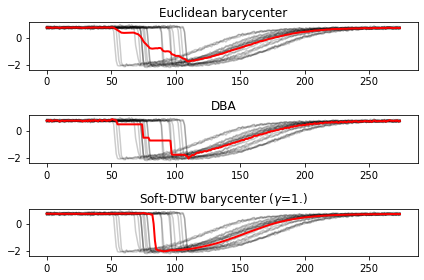

In [6]:
from tslearn.barycenters import euclidean_barycenter, dtw_barycenter_averaging, softdtw_barycenter
from tslearn.datasets import CachedDatasets

X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X = X_train[y_train == 2]

plt.figure()
plt.subplot(3, 1, 1)
for ts in X:
    plt.plot(ts.ravel(), "k-", alpha=.2)
plt.plot(euclidean_barycenter(X).ravel(), "r-", linewidth=2)
plt.title("Euclidean barycenter")

plt.subplot(3, 1, 2)
dba_bar = dtw_barycenter_averaging(X, max_iter=100, verbose=False)
for ts in X:
    plt.plot(ts.ravel(), "k-", alpha=.2)
plt.plot(dba_bar.ravel(), "r-", linewidth=2)
plt.title("DBA")

plt.subplot(3, 1, 3)
sdtw_bar = softdtw_barycenter(X, gamma=1., max_iter=100)
for ts in X:
    plt.plot(ts.ravel(), "k-", alpha=.2)
plt.plot(sdtw_bar.ravel(), "r-", linewidth=2)
plt.title("Soft-DTW barycenter ($\gamma$=1.)")

plt.tight_layout()
plt.show()

In [7]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
clf.fit([[1, 2, 3], [1, 1.2, 3.2], [3, 2, 1]], y=[0, 0, 1])
print(clf.predict([[1, 2.2, 3], [2, 2, 1]]))

[0 1]


In [8]:
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

#kNN with EUCLIDEAN
clf = KNeighborsTimeSeriesClassifier(metric="euclidean")
clf.fit(X_train,y_train)
print(y_test[1:10])
print(clf.predict(X_test[1:10]))

[1 3 2 1 3 2 2 2 4]
[2 4 2 2 4 2 2 2 3]


In [10]:
#kNN with DTW
clf = KNeighborsTimeSeriesClassifier(n_neighbors=2, metric="dtw")
clf.fit(X_train,y_train)
print(y_test[1:10])
print(clf.predict(X_test[1:10]))

[1 3 2 1 3 2 2 2 4]
[1 3 2 1 3 2 2 2 4]


In [11]:
from tslearn.piecewise import SymbolicAggregateApproximation
from sklearn.pipeline import Pipeline

#kNN with SAX representation
sax_trans = SymbolicAggregateApproximation(n_segments=50, alphabet_size_avg=5)
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="euclidean")
pipeline_model = Pipeline(steps=[('sax', sax_trans), ('knn', knn_clf)])
pipeline_model.fit(X_train, y_train)
print(y_test[1:10])
print(pipeline_model.predict(X_test[1:10]))

[1 3 2 1 3 2 2 2 4]
[1 4 1 1 4 2 2 1 4]


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from tslearn.generators import random_walk_blobs
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.neighbors import KNeighborsTimeSeriesClassifier, KNeighborsTimeSeries
from tslearn.piecewise import SymbolicAggregateApproximation

n_ts_per_blob, sz, d, n_blobs = 20, 100, 1, 2

# Prepare data
X, y = random_walk_blobs(n_ts_per_blob=n_ts_per_blob, sz=sz, d=d, n_blobs=n_blobs)
scaler = TimeSeriesScalerMinMax(min=0., max=1.)  # Rescale time series
X_scaled = scaler.fit_transform(X)

indices_shuffle = np.random.permutation(n_ts_per_blob * n_blobs)
X_shuffle = X_scaled[indices_shuffle]
y_shuffle = y[indices_shuffle]

X_train = X_shuffle[:n_ts_per_blob * n_blobs // 2]
X_test = X_shuffle[n_ts_per_blob * n_blobs // 2:]
y_train = y_shuffle[:n_ts_per_blob * n_blobs // 2]
y_test = y_shuffle[n_ts_per_blob * n_blobs // 2:]

# Nearest neighbor search
knn = KNeighborsTimeSeries(n_neighbors=3, metric="dtw")
knn.fit(X_train, y_train)
dists, ind = knn.kneighbors(X_test)
print("1. Nearest neighbour search")
print("Computed nearest neighbor indices (wrt DTW)\n", ind)
print("First nearest neighbor class:", y_test[ind[:, 0]])

# Nearest neighbor classification
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")
knn_clf.fit(X_train, y_train)
predicted_labels = knn_clf.predict(X_test)
print("\n2. Nearest neighbor classification using DTW")
print("Correct classification rate:", accuracy_score(y_test, predicted_labels))

# Nearest neighbor classification with a different metric (Euclidean distance)
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="euclidean")
knn_clf.fit(X_train, y_train)
predicted_labels = knn_clf.predict(X_test)
print("\n3. Nearest neighbor classification using L2")
print("Correct classification rate:", accuracy_score(y_test, predicted_labels))

# Nearest neighbor classification  based on SAX representation
sax_trans = SymbolicAggregateApproximation(n_segments=10, alphabet_size_avg=5)
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="euclidean")
pipeline_model = Pipeline(steps=[('sax', sax_trans), ('knn', knn_clf)])
pipeline_model.fit(X_train, y_train)
predicted_labels = pipeline_model.predict(X_test)
print("\n4. Nearest neighbor classification using SAX+MINDIST")
print("Correct classification rate:", accuracy_score(y_test, predicted_labels))

/Users/joaotiagoaparicio/anaconda3/lib/python3.7/site-packages/sklearn/base.py:553: DeprecationWarning: 'min' is deprecated in version 0.2 and will be removed in 0.4. Use value_range instead.
  return self.fit(X, **fit_params).transform(X)
/Users/joaotiagoaparicio/anaconda3/lib/python3.7/site-packages/sklearn/base.py:553: DeprecationWarning: 'max' is deprecated in version 0.2 and will be removed in 0.4. Use value_range instead.
  return self.fit(X, **fit_params).transform(X)


1. Nearest neighbour search
Computed nearest neighbor indices (wrt DTW)
 [[ 5  0 11]
 [ 5  0 18]
 [ 5  0 18]
 [ 6 14  3]
 [17  6  3]
 [12  9 11]
 [ 6 17  1]
 [ 3  6  2]
 [ 9 11  5]
 [ 6  7 16]
 [14  6  2]
 [14 17  2]
 [ 5  0 12]
 [12  5  9]
 [ 3 17 10]
 [10 14  7]
 [ 6  3  1]
 [ 9  5 15]
 [ 5 15  0]
 [ 5 11  0]]
First nearest neighbor class: [0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0]

2. Nearest neighbor classification using DTW
Correct classification rate: 1.0

3. Nearest neighbor classification using L2
Correct classification rate: 1.0

4. Nearest neighbor classification using SAX+MINDIST
Correct classification rate: 0.95


In [13]:
def euclid_dist(t1,t2):
    return math.sqrt(sum((t1-t2)**2))

In [14]:
def DTWDistance(s1, s2, w):
    DTW={}
    w = max(w, abs(len(s1)-len(s2)))
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return math.sqrt(DTW[len(s1)-1, len(s2)-1])

In [15]:
def LB_Keogh(s1, s2, r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return math.sqrt(LB_sum)


In [16]:
from sklearn.metrics import classification_report

def knn(X_train,y_train,X_test,y_test,w):
    preds=[]
    for i in range(len(X_test)):
        min_dist=float('inf')
        closest_seq=[]
        for j in range(len(X_train)):
            if LB_Keogh(X_test[i],X_train[j],5)<min_dist:
                dist=DTWDistance(X_test[i],X_train[j],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(y_train[j])
    return classification_report(y_test,preds)

In [17]:
print(knn(X_train, y_train, X_test[1:20], y_test[1:20], 4))

              precision    recall  f1-score   support

           0       0.47      1.00      0.64         9
           1       0.00      0.00      0.00        10

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/Users/joaotiagoaparicio/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
from tslearn.generators import random_walks
from tslearn.clustering import GlobalAlignmentKernelKMeans, TimeSeriesKMeans, silhouette_score


In [19]:
X_bis = [[1, 2, 4], [1, 2, 3], [2, 5, 8]]
km_bis = TimeSeriesKMeans(n_clusters=2, max_iter=5, metric="softdtw").fit(X_bis)

In [20]:
#distances between observations
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

print(silhouette_score(X_train[1:20], y_train[1:20], metric="euclidean"))
print(silhouette_score(X_train[1:20], y_train[1:20], metric="dtw"))

0.00047044292149644713
0.312632167332812


In [21]:
X = random_walks(n_ts=50, sz=32, d=1)

km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, verbose=False, random_state=0).fit(X)
print(km.cluster_centers_.shape)
print(km.cluster_centers_)

(3, 32, 1)
[[[ 0.13942153]
  [ 0.21693598]
  [ 0.92390692]
  [ 0.79474024]
  [ 0.91799697]
  [ 1.40613547]
  [ 1.52888601]
  [ 1.62426382]
  [ 1.83350329]
  [ 1.98289647]
  [ 2.20531152]
  [ 2.08616245]
  [ 2.18732757]
  [ 2.03645229]
  [ 1.82947477]
  [ 2.06339501]
  [ 2.23816914]
  [ 2.2212103 ]
  [ 2.17437696]
  [ 2.92492532]
  [ 3.17791381]
  [ 2.91142623]
  [ 3.00346931]
  [ 3.48097652]
  [ 3.86049131]
  [ 3.60440903]
  [ 3.58707675]
  [ 3.8287872 ]
  [ 3.79365251]
  [ 3.80456176]
  [ 4.13055107]
  [ 3.64581618]]

 [[-0.02387231]
  [-0.53342882]
  [-0.80921192]
  [-1.14368305]
  [-1.71170497]
  [-1.93805532]
  [-2.27295191]
  [-2.1863418 ]
  [-2.49177433]
  [-2.94392871]
  [-3.57641471]
  [-3.87327197]
  [-4.04071754]
  [-4.29364991]
  [-4.51534323]
  [-4.57836436]
  [-4.83269498]
  [-5.12186603]
  [-5.05538057]
  [-5.11661066]
  [-4.85287546]
  [-4.8275127 ]
  [-5.1489007 ]
  [-5.77632462]
  [-6.17349235]
  [-5.86543886]
  [-6.53835972]
  [-6.67645737]
  [-6.82694877]
  [-6.52883

In [22]:
#km = TimeSeriesKMeans(n_clusters=2, metric="dtw")
km_dba = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, 
                          max_iter_barycenter=5, verbose=False, random_state=0)
km_dba.fit(X)
print(km_dba.cluster_centers_.shape)
print(km_dba.cluster_centers_)

(3, 32, 1)
[[[ 0.21638043]
  [-0.2770392 ]
  [-0.24037108]
  [ 0.72357111]
  [-2.3588492 ]
  [-0.19206768]
  [-0.53298054]
  [ 0.06762131]
  [ 1.34097668]
  [ 0.39034862]
  [ 1.08624984]
  [ 1.35688723]
  [ 2.69254253]
  [ 2.64581669]
  [ 3.03737847]
  [ 3.88447711]
  [ 3.09298137]
  [ 3.08620555]
  [ 3.08620555]
  [ 3.06703408]
  [ 3.06923612]
  [ 3.17345149]
  [ 2.45940341]
  [ 0.90714285]
  [ 2.45426116]
  [ 2.90193881]
  [ 3.81612938]
  [ 6.22636649]
  [ 4.16493786]
  [ 4.37345104]
  [ 3.28979782]
  [ 3.63342986]]

 [[ 0.24047696]
  [-2.056885  ]
  [-0.37157682]
  [-0.99796046]
  [-1.92117402]
  [-1.76973735]
  [-2.89569482]
  [-2.95097664]
  [-3.66432488]
  [-2.91375561]
  [-3.30521352]
  [-4.4510144 ]
  [-4.25302887]
  [-4.89055738]
  [-4.85341814]
  [-4.85341814]
  [-5.45622822]
  [-4.71955442]
  [-4.71464862]
  [-4.56443125]
  [-3.25880193]
  [-4.61834039]
  [-4.52937375]
  [-4.87905323]
  [-5.59537014]
  [-5.57966583]
  [-6.74301834]
  [-5.46533107]
  [-5.24727905]
  [-4.47855

In [23]:


#km_bis = TimeSeriesKMeans(n_clusters=2, metric="softdtw")
km_sdtw = TimeSeriesKMeans(n_clusters=3, metric="softdtw", max_iter=5, max_iter_barycenter=5,
                           metric_params={"gamma_sdtw": .5}, verbose=False, random_state=0).fit(X)
print(km_sdtw.cluster_centers_.shape)
print(km_sdtw.cluster_centers_)



/Users/joaotiagoaparicio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 'gamma_sdtw' is deprecated in version 0.2 and will be removed in 0.4. Use `gamma` instead of `gamma_sdtw` as a `metric_params` key to remove this warning.
  """


(3, 32, 1)
[[[ 0.04743911]
  [-0.05928839]
  [ 0.81025429]
  [-0.62263185]
  [-2.42431304]
  [-0.57960591]
  [-0.09050922]
  [ 0.07673065]
  [ 1.25806589]
  [ 0.5124183 ]
  [ 1.09533849]
  [ 1.49219519]
  [ 2.51783648]
  [ 2.78236498]
  [ 3.02275532]
  [ 3.76368215]
  [ 3.26034473]
  [ 3.19039248]
  [ 3.14947787]
  [ 3.10614382]
  [ 3.05064257]
  [ 2.969473  ]
  [ 2.56752643]
  [ 0.98004594]
  [ 2.55857129]
  [ 3.14077724]
  [ 3.81003473]
  [ 6.3676392 ]
  [ 4.27287773]
  [ 4.72545406]
  [ 4.48340116]
  [ 2.87037995]]

 [[ 0.28018297]
  [-1.36621317]
  [-0.5288164 ]
  [-1.24856486]
  [-1.70591235]
  [-1.94433162]
  [-1.99925398]
  [-3.44700122]
  [-3.64136137]
  [-3.41374632]
  [-2.45424205]
  [-4.17503683]
  [-4.54282241]
  [-4.77991111]
  [-4.88146546]
  [-5.00002973]
  [-6.00034328]
  [-4.81897446]
  [-4.44669088]
  [-4.12942306]
  [-3.3748015 ]
  [-4.32558233]
  [-4.51402834]
  [-4.85814517]
  [-5.81197052]
  [-6.03713576]
  [-6.78745806]
  [-5.93206293]
  [-5.60789821]
  [-4.80804

In [24]:
gak_km = GlobalAlignmentKernelKMeans(n_clusters=3)
labels_gak = gak_km.fit_predict(X)


In [25]:


from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler



Euclidean k-means
9.304 --> 6.457 --> 6.457 --> 
DBA k-means
Init 1
1.399 --> 0.625 --> 0.474 --> 0.449 --> 0.449 --> 
Init 2
1.990 --> 0.922 --> 0.528 --> 0.439 --> 0.433 --> 0.433 --> 
Soft-DTW k-means
4.617 --> 

/Users/joaotiagoaparicio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: 'gamma_sdtw' is deprecated in version 0.2 and will be removed in 0.4. Use `gamma` instead of `gamma_sdtw` as a `metric_params` key to remove this warning.


0.317 --> 0.184 --> 0.188 --> 0.187 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.187 --> 0.187 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 


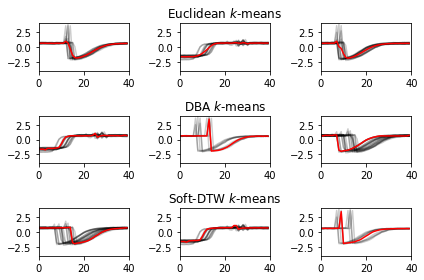

In [26]:
seed = 0
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = X_train[y_train < 4]  # Keep first 3 classes
np.random.shuffle(X_train)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])  # Keep only 50 time series
X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)  # Make time series shorter
sz = X_train.shape[1]

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3, n_init=2, metric="dtw", verbose=True, max_iter_barycenter=10, random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    if yi == 1:
        plt.title("DBA $k$-means")

# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3, metric="softdtw", metric_params={"gamma_sdtw": .01},
                           verbose=True, random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 7 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()


In [27]:
import random
def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=data[0:num_clust]
    counter=0
    for n in range(num_iter):
        counter+=1
        print(counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]

        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]

    return centroids

1
2
3
4
5
6
7
8
9
10


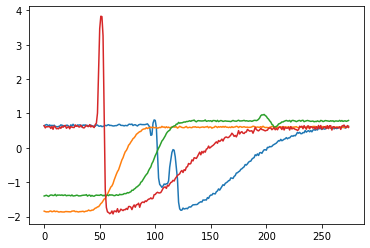

In [28]:
import matplotlib.pylab as pylt

X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
data=np.vstack((X_train,X_test))

centroids=k_means_clust(data[1:20],4,10,4)
for i in centroids: pylt.plot(i)
pylt.show()

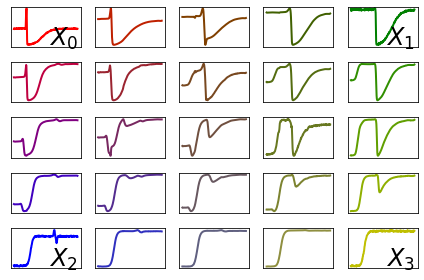

In [29]:
import matplotlib.colors
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.barycenters import softdtw_barycenter
from tslearn.datasets import CachedDatasets

def row_col(position, n_cols=5):
    idx_row = (position - 1) // n_cols
    idx_col = position - n_cols * idx_row - 1
    return idx_row, idx_col

def get_color(weights):
    baselines = np.zeros((4, 3))
    weights = np.array(weights).reshape(1, 4)
    for i, c in enumerate(["r", "g", "b", "y"]):
        baselines[i] = matplotlib.colors.ColorConverter().to_rgb(c)
    return np.dot(weights, baselines).ravel()

np.random.seed(0)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_out = np.empty((4, X_train.shape[1], X_train.shape[2]))

plt.figure()
for i in range(4):
    X_out[i] = X_train[y_train == (i + 1)][0]
X_out = TimeSeriesScalerMinMax().fit_transform(X_out)

for i, pos in enumerate([1, 5, 21, 25]):
    plt.subplot(5, 5, pos)
    w = [0.] * 4
    w[i] = 1.
    plt.plot(X_out[i].ravel(),color=matplotlib.colors.rgb2hex(get_color(w)),linewidth=2)
    plt.text(X_out[i].shape[0], 0., "$X_%d$" % i,
             horizontalalignment="right",verticalalignment="baseline",fontsize=24)
    plt.xticks([])
    plt.yticks([])

for pos in range(2, 25):
    if pos in [1, 5, 21, 25]:
        continue
    plt.subplot(5, 5, pos)
    idxr, idxc = row_col(pos, 5)
    w = np.array([0.] * 4)
    w[0] = (4 - idxr) * (4 - idxc) / 16
    w[1] = (4 - idxr) * idxc / 16
    w[2] = idxr * (4 - idxc) / 16
    w[3] = idxr * idxc / 16
    plt.plot(softdtw_barycenter(X_out,weights=w).ravel(),
             color=matplotlib.colors.rgb2hex(get_color(w)),linewidth=2)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()